In [100]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [65]:
all_predictions_df = pd.read_csv('./data/yolo_prediction/All.csv')
single_anns_df = pd.read_csv('./data/coco_diff/single_anns/person_anns.csv')

In [66]:
single_anns_df = single_anns_df.rename({'vis_face_ratio': 'head', 'vis_body_ratio': 'torso'}, axis=1)

In [67]:
single_anns_df['foot'] = (single_anns_df['left_ankle_v'] + single_anns_df['right_ankle_v'])/2
single_anns_df['arms'] = (single_anns_df['left_elbow_v'] + single_anns_df['right_elbow_v'])/2
single_anns_df['hand'] = (single_anns_df['left_wrist_v'] + single_anns_df['right_wrist_v'])/2
single_anns_df['legs'] = (single_anns_df['left_knee_v'] + single_anns_df['right_knee_v'])/2
single_anns_df['eyes'] = (single_anns_df['left_eye_v'] + single_anns_df['right_eye_v'])/2

In [68]:
single_anns_df['width'] = single_anns_df['width']/single_anns_df['img_width']
single_anns_df['height'] = single_anns_df['height']/single_anns_df['img_height']

In [69]:
single_anns_df['ID'] = (single_anns_df['Img'].astype(str) + (single_anns_df['person_num']-1).astype(str)).astype(int)

In [70]:
single_anns_df = single_anns_df[['ID', 'Img', 'person_num', 'area_norm', 'img_width', 'img_height', 'x', 'y', 'width', 'height', 'foot', 'legs', 'arms', 'eyes', 'head', 'hand', 'torso']]

In [71]:
single_pred_df = all_predictions_df.copy()

In [72]:
single_pred_df['x_pred'] = np.maximum(single_pred_df['x_center']-(single_pred_df['width'])/2, 0) # To avoid < 0 for rounding errors
single_pred_df['y_pred'] = np.maximum(single_pred_df['y_center']-(single_pred_df['height'])/2, 0) # To avoid < 0 for round errors

In [73]:
single_pred_df = single_pred_df[['ID', 'Img_ID', 'Confidence', 'x_pred', 'y_pred', 'width', 'height']]
single_pred_df = single_pred_df.rename({'width': 'width_pred', 'height': 'height_pred'}, axis=1)

In [74]:
single_anns_df['x'] = single_anns_df['x']/single_anns_df['img_width']
single_anns_df['y'] = single_anns_df['y']/single_anns_df['img_height']

In [75]:
single_merged = pd.merge(single_anns_df.drop(['ID'], axis=1), single_pred_df, left_on='Img', right_on='Img_ID', how='inner')

In [76]:
def calculate_iou_vectorized(df):
    x1_inter = df[['x', 'x_pred']].max(axis=1)
    y1_inter = df[['y', 'y_pred']].max(axis=1)
    x2_inter = (df['x'] + df['width']).clip(upper=(df['x_pred'] + df['width_pred']))
    y2_inter = (df['y'] + df['height']).clip(upper=(df['y_pred'] + df['height_pred']))

    inter_width = (x2_inter - x1_inter).clip(lower=0)
    inter_height = (y2_inter - y1_inter).clip(lower=0)
    intersection = inter_width * inter_height

    area_coco = df['width'] * df['height']
    area_yolo = df['width_pred'] * df['height_pred']
    union = area_coco + area_yolo - intersection

    return intersection / union 

In [78]:
single_merged['IoU'] = calculate_iou_vectorized(single_merged)

result_df = single_merged[single_merged['IoU'] > 0.5]
result_df[['ID', 'Img', 'Confidence', 'foot', 'head', 'torso', 'legs', 'arms', 'eyes', 'hand', 'area_norm']]


,ID,Img,Confidence,foot,head,torso,legs,arms,eyes,hand,area_norm
0,5224180,522418,0.778439,0.0,0.6,0.250,0.0,0.50,0.5,0.00,0.206137
2,1289391,128939,0.482966,0.0,0.0,0.375,0.0,0.50,0.0,0.00,0.005815
8,1289393,128939,0.324429,0.0,0.0,0.000,0.0,0.00,0.0,0.00,0.000791
13,1289390,128939,0.615011,0.0,0.0,0.500,0.0,0.50,0.0,0.50,0.052526
15,1289392,128939,0.387029,0.0,0.0,0.500,0.0,0.50,0.0,0.50,0.052526
...,...,...,...,...,...,...,...,...,...,...,...
31345,3574560,357456,0.875804,0.0,1.0,1.000,0.0,1.00,1.0,1.00,0.165172
31349,3574561,357456,0.359971,0.0,1.0,0.125,0.0,0.00,1.0,0.00,0.234665
31350,3574562,357456,0.274657,0.0,1.0,0.125,0.0,0.00,1.0,0.00,0.234665
31352,5160491,516049,0.488207,0.0,0.6,0.625,0.5,0.50,0.5,1.00,0.186221


In [79]:
attr_list = ['foot', 'torso', 'legs', 'arms', 'hand', 'eyes', 'head']
result_df = result_df[result_df[attr_list].sum(axis=1)>0]

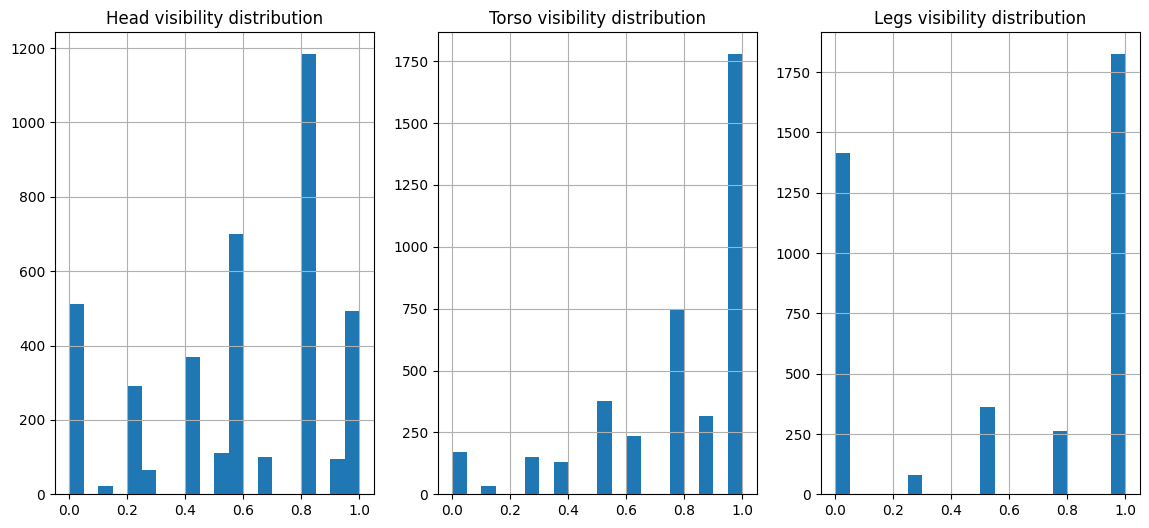

In [117]:
plt.figure(figsize=(14, 6))
plt.subplot(1, 3, 1)
plt.title('Head visibility distribution')
result_df['head'].hist(bins=20)
plt.subplot(1, 3, 2)
plt.title('Torso visibility distribution')
result_df['torso'].hist(bins=20)
plt.subplot(1, 3, 3)
plt.title('Legs visibility distribution')
result_df['legs'].hist(bins=20)
plt.show()

In [81]:
attr_list = ['foot', 'torso', 'legs', 'arms', 'hand']
result_df['head_compl'] = result_df[attr_list].sum(axis=1)
attr_list = ['foot', 'legs', 'arms', 'hand', 'head', 'eyes']
result_df['torso_compl'] = result_df[attr_list].sum(axis=1)
attr_list = ['foot', 'torso', 'arms', 'hand', 'head', 'eyes']
result_df['legs_compl'] = result_df[attr_list].sum(axis=1)


In [91]:
no_head = result_df[result_df['head']==0].head(50)[['head_compl', 'Confidence', 'ID', 'Img', 'area_norm']]
print(no_head['Confidence'].mean())
print(no_head['head_compl'].mean())
print()

no_torso = result_df[result_df['torso']==0].head(50)[['torso_compl', 'Confidence', 'ID', 'Img', 'area_norm']]
print(no_torso['Confidence'].mean())
print(no_torso['torso_compl'].mean())
print()


no_legs = result_df[result_df['legs']==0].head(50)[['legs_compl', 'Confidence', 'ID', 'Img', 'area_norm']]
print(no_legs['Confidence'].mean())
print(no_legs['legs_compl'].mean())
print()



0.6521254163980484
2.7575

0.6150216555595398
1.561

0.7291855949163437
2.8695



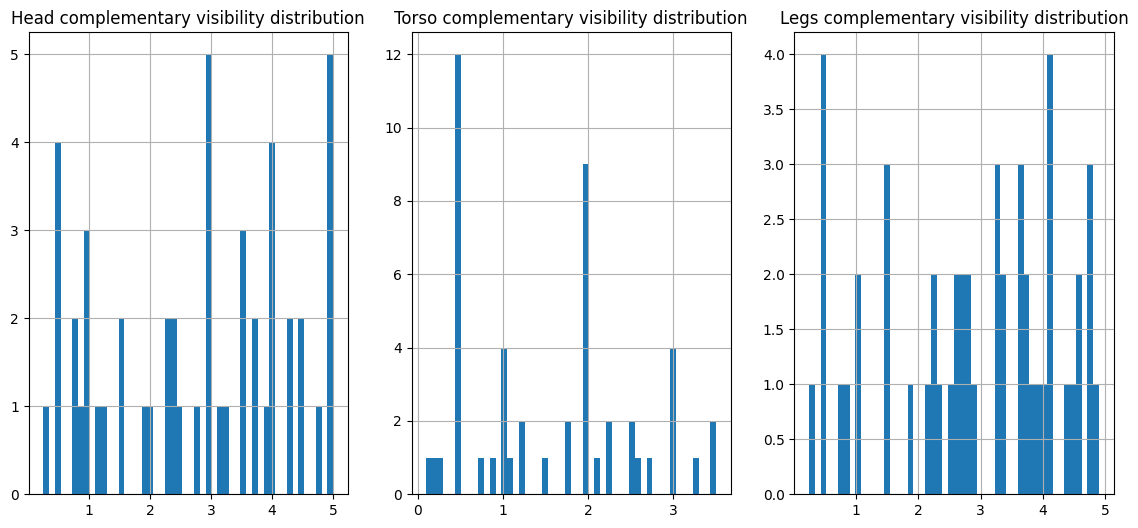

In [120]:
plt.figure(figsize=(14, 6))
plt.subplot(1, 3, 1)
plt.title('Head complementary visibility distribution')
no_head['head_compl'].hist(bins=50)
plt.subplot(1, 3, 2)
plt.title('Torso complementary visibility distribution')
no_torso['torso_compl'].hist(bins=50)
plt.subplot(1, 3, 3)
plt.title('Legs complementary visibility distribution')
no_legs['legs_compl'].hist(bins=50)
plt.show()

In [121]:
def plot_scatter(var, df, title):
    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(df[var],df['Confidence'], c=df['area_norm'], s=100, cmap='cividis', alpha=0.8, edgecolor='k')

    colorbar = plt.colorbar(scatter)
    colorbar.set_label('Person Area', fontsize=12)

    plt.xlabel(var, fontsize=12)
    plt.ylabel('Confidence', fontsize=12)
    plt.title(title, fontsize=14)

    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()


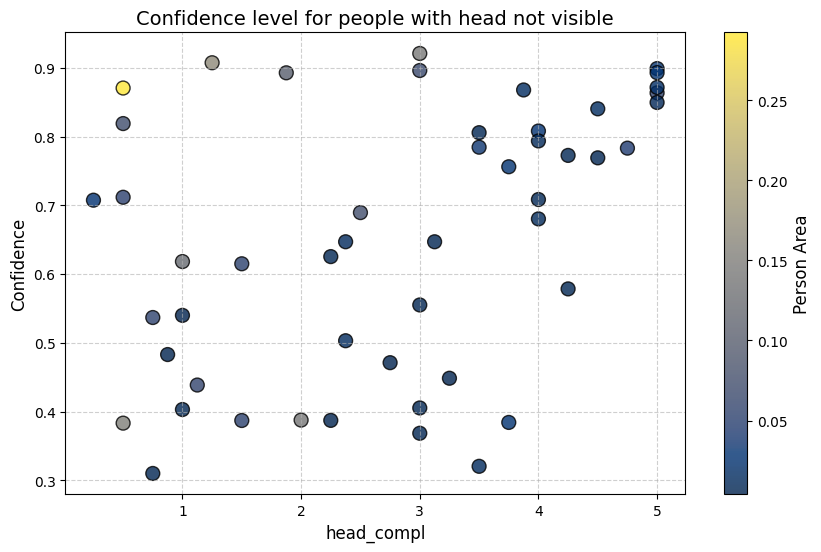

In [122]:
plot_scatter('head_compl', no_head, 'Confidence level for people with head not visible')

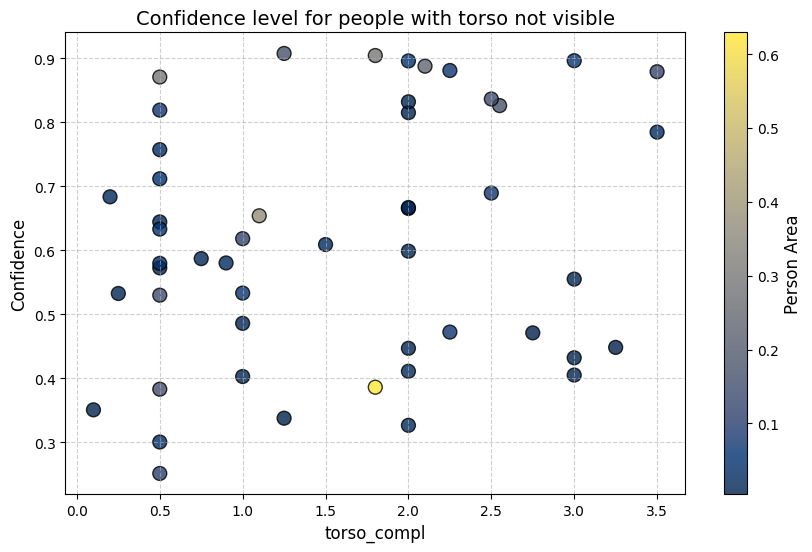

In [123]:
plot_scatter('torso_compl', no_torso, 'Confidence level for people with torso not visible')

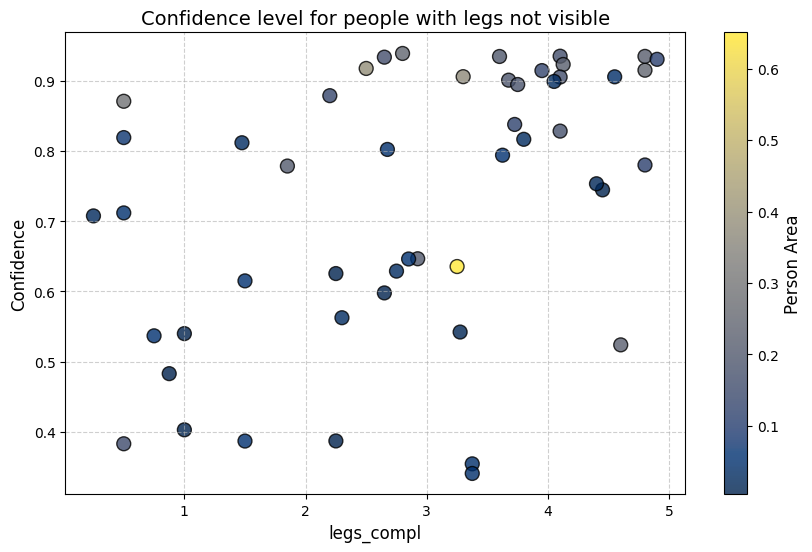

In [124]:
plot_scatter('legs_compl', no_legs, 'Confidence level for people with legs not visible')